# Project: Wrangling and Data Analysis - WeRateDogs

By Daniel Ogiku

### Introduction

The goal of this project is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

### Data Used for Analysis

Enhanced Twitter Archive: Downloaded this file manually by clicking the following link: twitter_archive_enhanced.csv

Additional Data via the Twitter API: Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

Image Predictions File: Dog breed (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


### Steps

Data wrangling, which consists of:
Gathering data
Assessing data
Cleaning data

Storing, analyzing, and visualizing our wrangled data

Reporting on 1) our data wrangling efforts and 2) our data analyses and visualizations

In [249]:
### Import libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json
import requests
import tweepy
import re
from tweepy import OAuthHandler
from timeit import default_timer as timer

%matplotlib inline

## Data Gathering

In [250]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [251]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [252]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [253]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [254]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


 My application for a Twitter developer account was rejected, to save time on my project I used the shortcut data provided from my Udacity dashboard

Store the JSON file in a dataframe

In [255]:
df2_list = []

with open('tweet_json.txt', 'r', encoding='utf8') as file:
    for line in file:
        lines = json.loads(line)
        df2_list.append({'tweet_id': lines['id'],
                        'favorite_count': lines['favorite_count'],
                        'retweet_count': lines['retweet_count']})
                        
dfjson = pd.DataFrame(df2_list, columns=['tweet_id','favorite_count','retweet_count','retweet_status'])

In [256]:
dfjson.head()

,tweet_id,favorite_count,retweet_count,retweet_status
0,892420643555336193,39467,8853,NaN
1,892177421306343426,33819,6514,NaN
2,891815181378084864,25461,4328,NaN
3,891689557279858688,42908,8964,NaN
4,891327558926688256,41048,9774,NaN


## Assessing Data

### Twitter_Archive

In [257]:
twitter_archive.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [258]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [259]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [260]:
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [261]:
sum(twitter_archive.duplicated())

0

In [262]:
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [263]:
np.sort(twitter_archive['rating_numerator'].unique())

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   20,   24,   26,   27,   44,
         45,   50,   60,   75,   80,   84,   88,   99,  121,  143,  144,
        165,  182,  204,  420,  666,  960, 1776])

In [264]:
np.sort(twitter_archive['rating_denominator'].unique())

array([  0,   2,   7,  10,  11,  15,  16,  20,  40,  50,  70,  80,  90,
       110, 120, 130, 150, 170])

In [265]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [266]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

#### twitter_archive columns:

tweet_id: the unique identifier for each tweet <br>
in_reply_to_status_id: if the tweet is a reply, this column will representing the original tweet id <br>
in_reply_to_user_id: if the tweet is a reply, this column will representing the original tweet's user id <br>
timestamp: date and time of the tweet <br>
source: utility used to post the tweet <br>
text: content of the tweet<br>
retweeted_status_id: if the tweet is retweet, this column will representing the original tweet id <br>
retweeted_status_user_id: if the tweet is retweet, this column will representing the original tweet's user id <br>
retweeted_status_timestamp: if the tweet is retweet, this column will representing the original tweet's time stamp <br>
expanded_urls: URL of the tweet <br>
rating_numerator: rating numerator of the dog mentioned in the tweet <br>
rating_denominator: rating denominator of the dog mentioned in the tweet <br>
name: the name of the dog <br>
doggo/ floofer/ pupper/ puppo: some nick names of different dog species at different ages.

### Image_predictions

In [267]:
image_predictions.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [268]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [269]:
image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [270]:
sum(image_predictions.duplicated())

0

In [271]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [272]:
image_predictions.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

image_predictions columns:
    
tweet_id: the unique identifier of the tweet <br>
jpg_url: the URL of the image <br>
img_num: image number of the tweet <br>
p1: the first prediction of the image with the most prediction confidence<br>
p1_conf: how confident the algorithm is in the first prediction<br>
p1_dog: whether or not the first prediction is a dog<br>
p2: the second prediction of the image with the second prediction confidence<br>
p2_conf: how confident the algorithm is in the second prediction<br>
p2_dog: whether or not the second prediction is a dog<br>
p3: the third prediction of the image with the third prediction confidence<br>
p3_conf: how confident the algorithm is in the third prediction<br>
p3_dog: whether or not the third prediction is a dog <br>   

### dfjson

In [273]:
dfjson.head(10)

,tweet_id,favorite_count,retweet_count,retweet_status
0,892420643555336193,39467,8853,NaN
1,892177421306343426,33819,6514,NaN
2,891815181378084864,25461,4328,NaN
3,891689557279858688,42908,8964,NaN
4,891327558926688256,41048,9774,NaN
5,891087950875897856,20562,3261,NaN
6,890971913173991426,12041,2158,NaN
7,890729181411237888,56848,16716,NaN
8,890609185150312448,28226,4429,NaN
9,890240255349198849,32467,7711,NaN


In [274]:
dfjson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
retweet_status    0 non-null float64
dtypes: float64(1), int64(3)
memory usage: 73.6 KB


In [275]:
dfjson.isnull().sum()

tweet_id             0
favorite_count       0
retweet_count        0
retweet_status    2354
dtype: int64

In [276]:
sum(dfjson.duplicated())

0

In [277]:
dfjson.describe()

,tweet_id,favorite_count,retweet_count,retweet_status
count,2.354000e+03,2354.000000,2354.000000,0.0
mean,7.426978e+17,8080.968564,3164.797366,NaN
std,6.852812e+16,11814.771334,5284.770364,NaN
min,6.660209e+17,0.000000,0.000000,NaN
25%,6.783975e+17,1415.000000,624.500000,NaN
50%,7.194596e+17,3603.500000,1473.500000,NaN
75%,7.993058e+17,10122.250000,3652.000000,NaN
max,8.924206e+17,132810.000000,79515.000000,NaN


In [278]:
dfjson.nunique()

tweet_id          2354
favorite_count    2007
retweet_count     1724
retweet_status       0
dtype: int64

dfjson columns:

tweet_id: the unique identifier of the tweet <br>
favorite_count: favorite counts of the tweet<br>
retweet_count: retweet counts of the tweet<br>
retweet_status: retweet status of the tweet<br>

### Quality Issue

-Incorrect datatype
img_num Column should be string not Integer datatype<br>
Change tweet_id from an integer to a string<br>
Source Column should be in Category datatype<br>
Timestamp: this column should be date-time format instead of string<br>
-Name Column contain some invalid names like a, an .....these are articles, adjectives not real dog names<br>
-Remove columns with too many missing values, to make the final dataset more   neat and tidy.<br>
-Delete retweets status - not necessary for this analysis<br>
-Check and drop duplicate values to make the final dataset more neat and tidy<br>
-p1, p2, p3: dog breed names are not all in lowercase<br>
-Source column is not readable<br>
-The numerator and denominator columns have invalid values

### Tidiness Issue

Move doggo, floofer, pupper and puppo columns into one column 'dog_type'. <br>
drop doggo, floofer, pupper, puppo columns<br>
merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes 

### Create a copy of the all dataset

In [279]:
twitter = twitter_archive.copy()
image = image_predictions.copy()
json = dfjson.copy()

## Cleaning Data

### Tidiness Issue

Merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes

### Define 
The datasets can be merged using python command CONCAT

### Code

In [280]:
dfnew = pd.concat([twitter, image, json], join='outer', axis=1)

### Test
All the three dataset have been merged .

In [281]:
dfnew.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,collie,0.156665,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,malinois,0.138584,True,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,redbone,0.360687,True,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,Rottweiler,0.243682,True,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,NaN


In [282]:
dfnew.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_id',
       'favorite_count', 'retweet_count', 'retweet_status'],
      dtype='object')

In [283]:
dfnew.shape

(2356, 33)

## Quality Issue

remove columns with too many missing values.

### Define

we an delete the column using Command DROP , for column Axis =1

### Code & Test
for testing we can display our dataset using .HEAD() method

In [284]:

dfnew.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id', 
           'retweeted_status_timestamp'], axis=1, inplace=True)
dfnew.head()

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,collie,0.156665,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,...,malinois,0.138584,True,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,...,redbone,0.360687,True,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,...,Rottweiler,0.243682,True,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,NaN


### Tidiness Issue

Move doggo, floofer, pupper and puppo columns into one column 'dog_type'.

### Define
we can extract the data of the column using .EXTRACT() method

### Code

In [285]:

'''
# Extract the text from the columns into the new dog_type colunn
dfnew['dog_type'] = dfnew['text'].str.extract('(doggo|floofer|pupper|puppo)')

'''

"\n# Extract the text from the columns into the new dog_type colunn\ndfnew['dog_type'] = dfnew['text'].str.extract('(doggo|floofer|pupper|puppo)')\n\n"

There are cases where there are multiple dog stages in a row

In [286]:

dfnew.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


In [287]:
dfnew.doggo.replace('None', '', inplace=True) 
dfnew.doggo.replace(np.NaN, '', inplace=True)
dfnew.floofer.replace('None', '', inplace=True) 
dfnew.floofer.replace(np.NaN, '', inplace=True)
dfnew.pupper.replace('None', '', inplace=True) 
dfnew.pupper.replace(np.NaN, '', inplace=True)
dfnew.puppo.replace('None', '', inplace=True) 
dfnew.puppo.replace(np.NaN, '', inplace=True)

In [288]:
dfnew['dogtype'] = dfnew.doggo + dfnew.floofer + dfnew.pupper + dfnew.puppo
dfnew.loc[dfnew.dogtype == 'doggopupper', 'dog_type'] = 'doggo, pupper'
dfnew.loc[dfnew.dogtype == 'doggopuppo', 'dog_type'] = 'doggo, puppo'
dfnew.loc[dfnew.dogtype == 'doggofloofer', 'dog_type'] = 'doggo, floofer'

In [289]:
dfnew.dogtype.value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: dogtype, dtype: int64

In [290]:
dfnew.dogtype.unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

In [291]:
for idx, row in dfnew.iterrows():
    if ('doggoNoneNoneNone' in row['dogtype']):
        dfnew.loc[idx, 'dog_type'] = 'doggo'
    elif ('NoneNoneNonepuppo' in row['dogtype']):
        dfnew.loc[idx, 'dog_type'] = 'puppo'
    elif ('NoneNonepupperNone' in row['dogtype']):
        dfnew.loc[idx, 'dog_type'] = 'pupper'
    elif ('NoneflooferNoneNone' in row['dogtype']):
        dfnew.loc[idx, 'dog_type'] = 'floofer'
    elif ('NoneNoneNoneNone' in row['dogtype']):
        dfnew.loc[idx, 'dog_type'] = None
    else:
       dfnew.loc[idx, 'dog_type'] = 'multiple'
dfnew.head()

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dogtype,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,NaN,NoneNoneNoneNone,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,True,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,NaN,NoneNoneNoneNone,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,...,True,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,NaN,NoneNoneNoneNone,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,...,True,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,NaN,NoneNoneNoneNone,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,...,True,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,NaN,NoneNoneNoneNone,None


In [292]:
dfnew= dfnew.drop(['dogtype'] , axis =1)

### Test

we can check the values of our newly created column

In [293]:
dfnew.dog_type.value_counts()

pupper      245
doggo        83
puppo        29
multiple     14
floofer       9
Name: dog_type, dtype: int64

### Tidiness Issue

drop doggo, floofer, pupper, puppo columns

### Define

we can delete any column using .DROP() Method

### Code

In [294]:
dfnew.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

### Test

verify by displaying the dataset

In [295]:
dfnew.head(1)

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,6.660209e+17,...,0.156665,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,NaN,None


### Quality Isssue
img_num Column should be string not Integer datatype

### Define
we can convert the dataype using .ASTYPE() method

### Code

In [296]:
dfnew['img_num'] = dfnew['img_num'].astype(str)

### Test

we can check the datatype using type method

In [297]:
dfnew.columns.get_loc("img_num")

11

In [298]:
type(dfnew.iloc[0,11])

str

### Quality Issues
Change tweet_id from an integer to a string

### Define
we can convert the dataype using .ASTYPE() method

### Code

In [299]:
dfnew['tweet_id'] = dfnew['tweet_id'].astype(str)

### Test

we can check the datatype using type method

In [300]:
type(dfnew.iloc[0,0])

str

### Quality Issue
 Source Column should be in Category datatype

### Define
we can convert the dataype using .ASTYPE() method

### Code 

In [301]:
# Changing Data types to appropriate 
twitter_archive['source'] = twitter_archive['source'].astype('category')

### Test
we can check the datatype using type method

In [302]:
dfnew.columns.get_loc("source")

2

In [303]:
dfnew.source.dtype

dtype('O')

### Quality Issue
Timestamp is not of datetime format .

### Define 

for datetime format <br>
%b Month name, short version Dec <br>
%B Month name, full version December <br>
%m Month as a number 01-12 12<br>
%Y Year, full version<br>
%d Day of month 01-31

### Code

In [304]:
# Change the 'timestamp' column to a datetime object
dfnew['timestamp'] = pd.to_datetime(dfnew['timestamp'], format = "%Y-%m-%d ")

In [305]:
dfnew.head(2)

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dog_type
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,6.66020888023e+17,...,0.156665,True,Shetland_sheepdog,0.061428,True,8.92420643555e+17,39467.0,8853.0,NaN,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6.66029285003e+17,...,0.074192,True,Rhodesian_ridgeback,0.072010,True,8.92177421306e+17,33819.0,6514.0,NaN,None


### Quality Issue 
 Name Column contain some invalid names like a, an..... etc


### Define
we can replace incorrect names with None using .REPLACE() Method

### Code

In [306]:
dfnew['name'] = dfnew.name.replace(['None', 'a', 'an', 'very','the', 'not', 'quite', 'actually'], 'None' , inplace = True)

### Test 
we can check if any row with name equals to these is present or not

In [307]:
dfnew[dfnew['name']=='a']

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dog_type


### Quality Issue
Delete retweets 

### Define
we can delete any column using .DROP() method

### Code 

In [308]:

dfnew = dfnew.drop(['retweeted_status_id'] , axis=1)

### Test
we can check if any column named retweeted_status_id is present or not

In [309]:
dfnew.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'tweet_id', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'tweet_id', 'favorite_count', 'retweet_count',
       'retweet_status', 'dog_type'],
      dtype='object')

### Quality Issue
Checking for duplicate values and deleteing them

### Define 
we can check duplicate value using .DUPLICATED method

 ### Code

In [310]:
dfnew.drop_duplicates(inplace = True)

### Test
if any value present

In [311]:
dfnew[dfnew.duplicated()].sum()

tweet_id              0.0
timestamp             0.0
source                0.0
text                  0.0
expanded_urls         0.0
rating_numerator      0.0
rating_denominator    0.0
name                  0.0
tweet_id              0.0
jpg_url               0.0
img_num               0.0
p1                    0.0
p1_conf               0.0
p1_dog                0.0
p2                    0.0
p2_conf               0.0
p2_dog                0.0
p3                    0.0
p3_conf               0.0
p3_dog                0.0
tweet_id              0.0
favorite_count        0.0
retweet_count         0.0
retweet_status        0.0
dog_type              0.0
dtype: float64

### Quality Issue
p1, p2, p3: dog breed names are not all in lowercase

### Define
Turn them into lower case

### Code

In [312]:
dfnew['p1'] = dfnew['p1'].str.lower()
dfnew['p2'] = dfnew['p2'].str.lower()
dfnew['p3'] = dfnew['p3'].str.lower()

### Test

In [313]:
dfnew.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,jpg_url,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dog_type
2084,670807719151067136,2015-11-29 03:33:17,"<a href=""http://twitter.com/download/iphone"" r...","Say hello to Andy. He can balance on one foot,...",https://twitter.com/dog_rates/status/670807719...,11,10,None,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,6.70803562457e+17,362.0,95.0,NaN,None
2016,672169685991993344,2015-12-02 21:45:16,"<a href=""http://twitter.com/download/iphone"" r...",This is Bradley. That is his sandwich. He carr...,https://twitter.com/dog_rates/status/672169685...,10,10,None,8.79862464716e+17,https://pbs.twimg.com/media/DDXmPrbWAAEKMvy.jpg,...,0.146654,True,cocker_spaniel,0.009485,True,6.7213935016e+17,1876.0,792.0,NaN,None
2022,672068090318987265,2015-12-02 15:01:33,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Gizmo. He's upset because he's no...,https://twitter.com/dog_rates/status/672068090...,7,10,None,8.81268444196e+17,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,...,0.245646,False,ibex,0.055661,False,6.71891728107e+17,1415.0,618.0,NaN,None
868,761750502866649088,2016-08-06 02:27:27,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Tristan do not speak to me wit...",https://twitter.com/dog_rates/status/685325112...,10,10,None,6.97596423849e+17,https://pbs.twimg.com/media/Ca5cPrJXIAImHtD.jpg,...,0.366578,True,pembroke,0.007698,True,7.61672994377e+17,55016.0,33421.0,NaN,None
1129,729463711119904772,2016-05-09 00:11:16,"<a href=""http://twitter.com/download/iphone"" r...",Meet Pupcasso. You can't afford his art. 13/10...,https://twitter.com/dog_rates/status/729463711...,13,10,None,7.28015554473e+17,https://pbs.twimg.com/media/ChpuRyvVAAARMoq.jpg,...,0.091661,True,sandbar,0.081799,False,7.28986383097e+17,3460.0,917.0,NaN,None


### Quality Issues
Source column not readable

### Define
Make source column clean and readable

### Code

In [314]:
dfnew['source'] = dfnew['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

### Test

In [315]:
dfnew.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,jpg_url,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dog_type
1101,735635087207878657,2016-05-26 00:54:06,Twitter for iPhone,This is Dakota. He hasn't grow into his skin y...,https://twitter.com/dog_rates/status/735635087...,11,10,None,7.20785406565e+17,https://pbs.twimg.com/media/CgC-gMCWcAAawUE.jpg,...,0.027929,False,kelpie,0.017916,True,7.35256018285e+17,3675.0,993.0,NaN,None
682,788552643979468800,2016-10-19 01:29:35,Twitter for iPhone,RT @dog_rates: Say hello to mad pupper. You kn...,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,None,6.83834909292e+17,https://pbs.twimg.com/ext_tw_video_thumb/68383...,...,0.102992,True,samoyed,0.023247,True,7.88412144019e+17,16060.0,5990.0,NaN,pupper
1933,674019345211760640,2015-12-08 00:15:09,Twitter for iPhone,This is Acro. You briefly see her out of the c...,https://twitter.com/dog_rates/status/674019345...,10,10,None,8.59607811542e+17,https://pbs.twimg.com/media/C-3wvtxXcAUTuBE.jpg,...,0.024099,True,labrador_retriever,0.019285,True,6.74008982932e+17,1297.0,393.0,NaN,None
1131,728986383096946689,2016-05-07 16:34:32,Twitter for iPhone,This is Puff. He started out on the streets (f...,https://twitter.com/dog_rates/status/728986383...,11,10,None,7.28046963733e+17,https://pbs.twimg.com/media/ChqK2cVWMAAE5Zj.jpg,...,0.175583,True,german_shepherd,0.164135,True,7.28751179682e+17,3032.0,757.0,NaN,None
1577,687399393394311168,2016-01-13 22:22:41,Vine - Make a Scene,This is Barry. He's very fast. I hope he finds...,https://vine.co/v/iM2hLu9LU5i,10,10,None,7.96116448414e+17,https://pbs.twimg.com/media/CwxfrguUUAA1cbl.jpg,...,0.260738,True,papillon,0.017110,True,6.87312378586e+17,4777.0,2146.0,NaN,None


### Quality Issues
The numerator and denominator columns have invalid value

### Define
Fix rating numerator and denominators that are not ratings

### Code

In [316]:
tmp_rating = dfnew[dfnew.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

for i in tmp_rating:
    x = dfnew.text == i
    column_1 = 'rating_numerator'
    column_2 = 'rating_denominator'
    dfnew.loc[x, column_1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", i)
    dfnew.loc[x, column_2] = 10

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


### Test

In [317]:
dfnew[dfnew.text.isin(tmp_rating)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,jpg_url,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,dog_type
55,881633300179243008,2017-07-02 21:58:53,Twitter for iPhone,@roushfenway These are good dogs but 17/10 is ...,NaN,13,10,None,6.67062181243e+17,https://pbs.twimg.com/media/CUHhgvHUAAA4aB0.jpg,...,0.090998,True,kelpie,0.022956,True,8.81536004381e+17,50199.0,16570.0,NaN,None
313,835246439529840640,2017-02-24 21:54:03,Twitter for iPhone,@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,13,10,None,6.71561002136e+17,https://pbs.twimg.com/media/CVHdK-7WwAAsuyc.jpg,...,0.270893,True,rottweiler,0.153233,True,8.35172783152e+17,28552.0,6516.0,NaN,None
561,802624713319034886,2016-11-26 21:26:58,Twitter for iPhone,"RT @dog_rates: ""Yep... just as I suspected. Yo...",https://twitter.com/dog_rates/status/777684233...,11,10,None,6.77895101218e+17,https://pbs.twimg.com/media/CWhd_7WWsAAaqWG.jpg,...,0.060226,True,great_pyrenees,0.058631,True,8.02600418707e+17,7938.0,1714.0,NaN,None
766,777684233540206592,2016-09-19 01:42:24,Twitter for iPhone,"""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,11,10,None,6.89154315266e+17,https://pbs.twimg.com/media/CZBeMMVUwAEdVqI.jpg,...,0.054135,True,airedale,0.030648,True,7.77641927919e+17,0.0,4947.0,NaN,None
784,775096608509886464,2016-09-11 22:20:06,Twitter for iPhone,"RT @dog_rates: After so many requests, this is...",https://twitter.com/dog_rates/status/740373189...,14,10,None,6.90021994562e+17,https://pbs.twimg.com/media/CZNzV6cW0AAsX7p.jpg,...,0.099140,False,malamute,0.040696,True,7.750851326e+17,17281.0,5488.0,NaN,None
860,763167063695355904,2016-08-10 00:16:21,Twitter for iPhone,RT @dog_rates: Meet Eve. She's a raging alcoho...,https://twitter.com/dog_rates/status/673295268...,11,10,None,6.96900204697e+17,https://pbs.twimg.com/media/CavjCdJW0AIB5Oz.jpg,...,0.266953,True,basenji,0.136814,True,7.6269985813e+17,13518.0,4190.0,NaN,pupper
1007,747600769478692864,2016-06-28 01:21:27,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,7,10,None,7.09198395643e+17,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,...,0.083513,True,english_setter,0.083184,True,7.47512671126e+17,6110.0,1803.0,NaN,None
1068,740373189193256964,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,14,10,None,7.15928423106e+17,https://pbs.twimg.com/media/Ce99GhLW8AAHG38.jpg,...,0.019663,True,bull_mastiff,0.002278,True,7.40359016049e+17,3610.0,967.0,NaN,None
1165,722974582966214656,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,13,10,None,7.35274964363e+17,https://pbs.twimg.com/media/CjQ4radW0AENP-m.jpg,...,0.007942,False,quilt,0.006302,False,7.21503162399e+17,5086.0,2124.0,NaN,None
1202,716439118184652801,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,11,10,None,7.41303864243e+17,https://pbs.twimg.com/media/Ckmj7mNWYAA4NzZ.jpg,...,0.014902,True,pekinese,0.012816,True,7.16080869887e+17,5272.0,1935.0,NaN,None


#### Storing our Cleaned data into CSV File

In [318]:
# storing the dataset
dfnew.to_csv('twitter_archive_master.csv', encoding='utf-8')

## Visualizating and Analyzing Data

Importing our cleaned dataset

In [319]:
twitter_archive = pd.read_csv('twitter_archive_master.csv')

In [320]:
twitter_archive.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id.1,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id.2,favorite_count,retweet_count,retweet_status,dog_type
0,0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,NaN,6.660209e+17,...,0.156665,True,shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,NaN,NaN
1,1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,6.660293e+17,...,0.074192,True,rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,NaN,NaN
2,2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,6.660334e+17,...,0.138584,True,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,NaN,NaN
3,3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,6.660442e+17,...,0.360687,True,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,NaN,NaN
4,4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,6.660492e+17,...,0.243682,True,doberman,0.154629,True,8.913276e+17,41048.0,9774.0,NaN,NaN


In [321]:
twitter_archive.drop(['Unnamed: 0'] , axis = 1 , inplace = True)
twitter_archive.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id.1,jpg_url,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id.2,favorite_count,retweet_count,retweet_status,dog_type
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,NaN,6.660209e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,...,0.156665,True,shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,6.660293e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,...,0.074192,True,rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,NaN,NaN


In [322]:
twitter_archive.shape

(2356, 25)

### First Insight
### What source are people using the most?

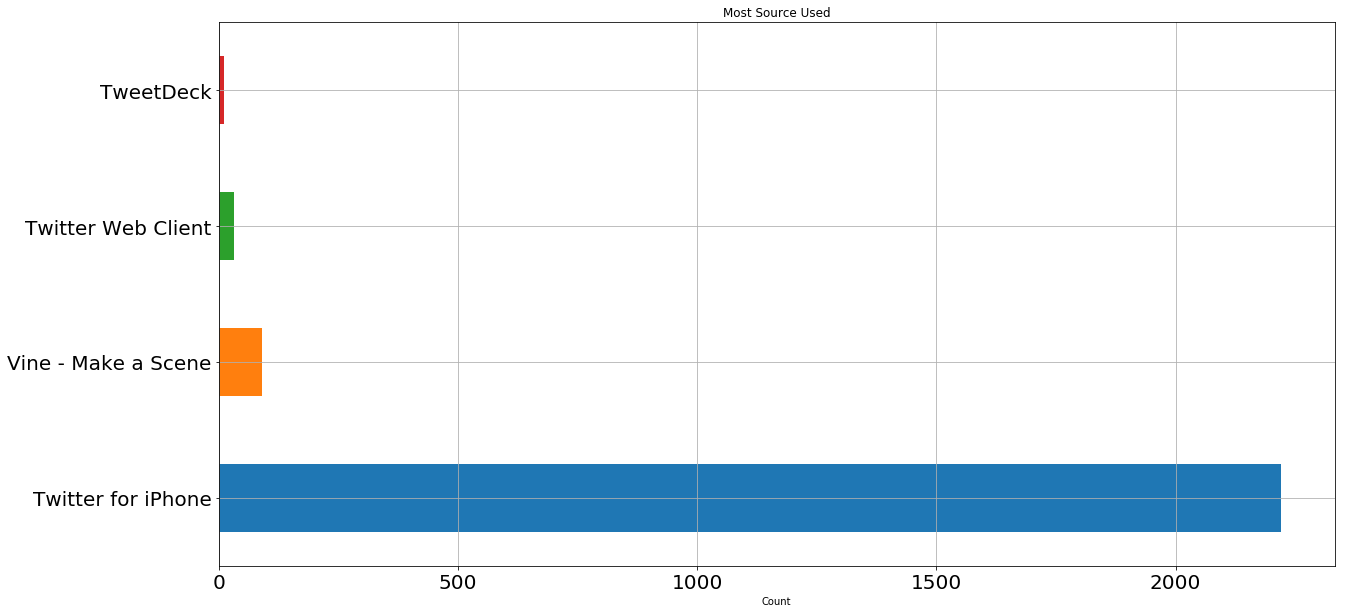

In [323]:
temp_df = twitter_archive['source'].value_counts()

temp_df.plot(kind='barh', figsize=(20,10),grid=True, fontsize =20,
             title = 'Most Source Used').set_xlabel('Count')
 
plt.show()

#save pic
plt.savefig('most_used_source.png', dpi=100)


### Observation
Most people are using Twitter for iPhone to engage

### Second Insight
### What is the most common dog type

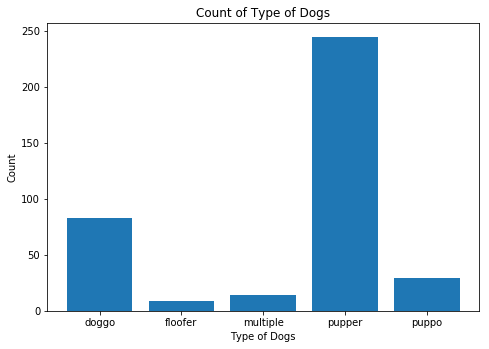

In [324]:
count=list(twitter_archive['dog_type'].value_counts().sort_values())
label=list(twitter_archive['dog_type'].value_counts().sort_values().index)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(label,count)
plt.xlabel("Type of Dogs")
plt.ylabel("Count")
ax.set_title("Count of Type of Dogs")
plt.show()

#save pic
plt.savefig('most_common_dog_type.png', dpi=100)

### Observation
From the graphical illustration above Pupper is the most common owned dog, followed by Doggo

### Third Insight
### What dog breed do people love the most?

In [325]:
dog_fav = twitter_archive.groupby('p1')['favorite_count'].sum().sort_values(ascending=False).head(6)
dog_fav

p1
golden_retriever      1008182.0
labrador_retriever     911072.0
chihuahua              752399.0
pembroke               733586.0
toy_poodle             464679.0
pug                    399731.0
Name: favorite_count, dtype: float64

In [326]:
dog_ret = twitter_archive.groupby('p1')['retweet_count'].sum().sort_values(ascending=False).head(6)
dog_ret

p1
golden_retriever      366962.0
chihuahua             323065.0
labrador_retriever    308581.0
pembroke              268212.0
toy_poodle            190275.0
samoyed               181688.0
Name: retweet_count, dtype: float64

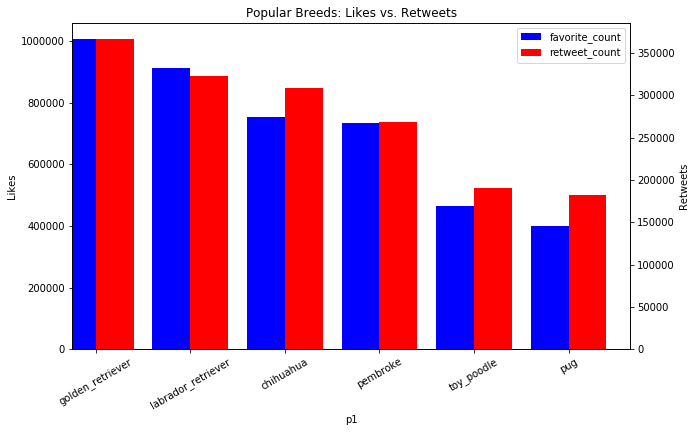

In [327]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


dog_fav.plot(figsize = (10,6), kind='bar', color='blue', ax=ax1, width=0.4, position=1, 
             title='Popular Breeds: Likes vs. Retweets')
dog_ret.plot(figsize = (10,6), kind='bar', color='red', ax=ax2, width=0.4, position=0)

ax1.set_ylabel('Likes')
ax2.set_ylabel('Retweets')
ax1.set_xticklabels(dog_fav.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

### Observation
Based on likes and retweet, golden retriever is the most loved dog breed 

### Fourth Insight
### What is the relation between Retweets & Likes?

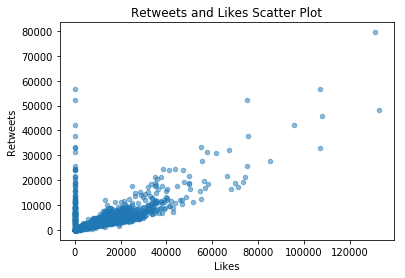

In [328]:
#Retweets vs. Likes

twitter_archive.plot(kind='scatter',x='favorite_count',y='retweet_count', alpha = 0.5)
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Retweets and Likes Scatter Plot')

plt.savefig('Retweets_vs_Likes.png', bbox_inches='tight')

### Observations
Retweets are positively correlated with Likes.

## Sources

 https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes/44338256
 
https://stackoverflow.com/questions/13021654/get-column-index-from-column-name-in-python-pandas

https://www.w3schools.com/python/python_datetime.asp

https://stackoverflow.com/questions/48140858/json-decoder-jsondecodeerror-extra-data-line-2-column-1-char-190?noredirect=1&lq=1

https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/

https://stackoverflow.com/questions/16435042/dict-object-has-no-attribute-loads

https://numpy.org/doc/stable/reference/generated/numpy.isnan.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html

https://stackoverflow.com/questions/50491747/extracting-the-meaningful-information-from-the-text-column-using-python

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html

In [329]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'wrangle_act.ipynb'])

0